In [2]:
!python -V

Python 3.9.19


In [1]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

2024/07/03 15:55:27 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1720022127260, experiment_id='1', last_update_time=1720022127260, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [4]:
link = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'
data = 'green_tripdata_2021-01.parquet'

datapath = link + data

In [5]:
df = pd.read_parquet(datapath)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

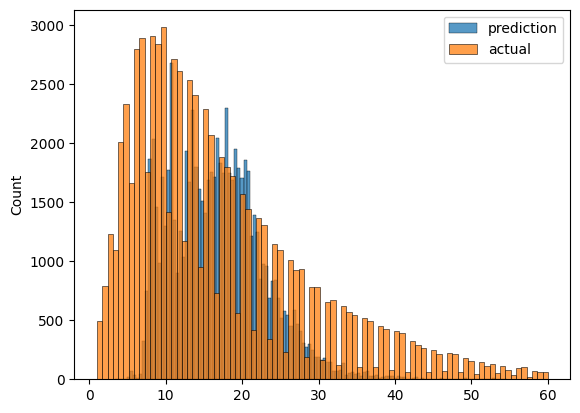

In [7]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
data_train = 'green_tripdata_2021-01.parquet'
datapath_train = link + data_train

data_val = 'green_tripdata_2021-02.parquet'
datapath_val = link + data_val

In [10]:
df_train = read_dataframe(datapath_train)
df_val = read_dataframe(datapath_val)

len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
# Training Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [20]:
!mkdir models

In [24]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [36]:
# Training Lasso Model
with mlflow.start_run():

    mlflow.set_tag('developer', 'kerem')
    mlflow.log_param('train-data-path', datapath_train)
    mlflow.log_param('valid-data-path', datapath_val)

    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_artifact('models/')

In [ ]:
# Xgboost & Hyperparameter Tuning

In [16]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [18]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [19]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [23]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45024                          
[1]	validation-rmse:10.78146                          
[2]	validation-rmse:10.19758                          
[3]	validation-rmse:9.68957                           
[4]	validation-rmse:9.24957                           
[5]	validation-rmse:8.86832                           
[6]	validation-rmse:8.54018                           
[7]	validation-rmse:8.25769                           
[8]	validation-rmse:8.01623                           
[9]	validation-rmse:7.81030                           
[10]	validation-rmse:7.63521                          
[11]	validation-rmse:7.48569                          
[12]	validation-rmse:7.35838                          
[13]	validation-rmse:7.25025                          
[14]	validation-rmse:7.15763                          
[15]	validation-rmse:7.07949                          
[16]	validation-rmse:7.01170                          
[17]	validation-rmse:6.95444                          
[18]	valid

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45850                                                     
[1]	validation-rmse:10.79535                                                     
[2]	validation-rmse:10.21445                                                     
[3]	validation-rmse:9.70749                                                      
[4]	validation-rmse:9.26639                                                      
[5]	validation-rmse:8.88440                                                      
[6]	validation-rmse:8.55384                                                      
[7]	validation-rmse:8.27009                                                      
[8]	validation-rmse:8.02511                                                      
[9]	validation-rmse:7.81480                                                      
[10]	validation-rmse:7.63443                                                     
[11]	validation-rmse:7.48216                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28154                                                      
[1]	validation-rmse:10.49518                                                      
[2]	validation-rmse:9.83260                                                       
[3]	validation-rmse:9.27790                                                       
[4]	validation-rmse:8.81728                                                       
[5]	validation-rmse:8.43406                                                       
[6]	validation-rmse:8.12091                                                       
[7]	validation-rmse:7.86353                                                       
[8]	validation-rmse:7.65047                                                       
[9]	validation-rmse:7.47622                                                       
[10]	validation-rmse:7.33424                                                      
[11]	validation-rmse:7.21805                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69269                                                     
[1]	validation-rmse:11.21751                                                     
[2]	validation-rmse:10.78113                                                     
[3]	validation-rmse:10.38408                                                     
[4]	validation-rmse:10.02253                                                     
[5]	validation-rmse:9.69060                                                      
[6]	validation-rmse:9.39116                                                      
[7]	validation-rmse:9.11916                                                      
[8]	validation-rmse:8.87258                                                      
[9]	validation-rmse:8.64960                                                      
[10]	validation-rmse:8.44702                                                     
[11]	validation-rmse:8.26643                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.84277                                                       
[3]	validation-rmse:6.77071                                                       
[4]	validation-rmse:6.75086                                                       
[5]	validation-rmse:6.73732                                                       
[6]	validation-rmse:6.73046                                                       
[7]	validation-rmse:6.72503                                                       
[8]	validation-rmse:6.72109                                                       
[9]	validation-rmse:6.71724                                                       
[10]	validation-rmse:6.71468                                                      
[11]	validation-rmse:6.71387                                                      
[12]	validation-rmse:6.70850                                                      
[13]	validation-rmse:6.70622                                                      
[14]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.36198                                                     
[1]	validation-rmse:9.07901                                                      
[2]	validation-rmse:8.20701                                                      
[3]	validation-rmse:7.63079                                                      
[4]	validation-rmse:7.25314                                                      
[5]	validation-rmse:7.00706                                                      
[6]	validation-rmse:6.84784                                                      
[7]	validation-rmse:6.74130                                                      
[8]	validation-rmse:6.66762                                                      
[9]	validation-rmse:6.61663                                                      
[10]	validation-rmse:6.58193                                                     
[11]	validation-rmse:6.55585                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.71761                                                    
[1]	validation-rmse:8.28185                                                    
[2]	validation-rmse:7.49323                                                    
[3]	validation-rmse:7.07113                                                    
[4]	validation-rmse:6.84582                                                    
[5]	validation-rmse:6.71929                                                    
[6]	validation-rmse:6.64738                                                    
[7]	validation-rmse:6.60496                                                    
[8]	validation-rmse:6.57512                                                    
[9]	validation-rmse:6.55696                                                    
[10]	validation-rmse:6.53960                                                   
[11]	validation-rmse:6.52994                                                   
[12]	validation-rmse:6.51944            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:45:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.28962                                                    
[2]	validation-rmse:8.45126                                                    
[3]	validation-rmse:7.88249                                                    
[4]	validation-rmse:7.50132                                                    
[5]	validation-rmse:7.24858                                                    
[6]	validation-rmse:7.07993                                                    
[7]	validation-rmse:6.96666                                                    
[8]	validation-rmse:6.89018                                                    
[9]	validation-rmse:6.83728                                                    
[10]	validation-rmse:6.79791                                                   
[11]	validation-rmse:6.77127                                                   
[12]	validation-rmse:6.75089                                                   
[13]	validation-rmse:6.73696            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:46:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59141                                                   
[1]	validation-rmse:11.03096                                                   
[2]	validation-rmse:10.52622                                                   
[3]	validation-rmse:10.07230                                                   
[4]	validation-rmse:9.66629                                                    
[5]	validation-rmse:9.30185                                                    
[6]	validation-rmse:8.97723                                                    
[7]	validation-rmse:8.68847                                                    
[8]	validation-rmse:8.43274                                                    
[9]	validation-rmse:8.20432                                                    
[10]	validation-rmse:8.00311                                                   
[11]	validation-rmse:7.82613                                                   
[12]	validation-rmse:7.66927            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:49:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53758                                                    
[1]	validation-rmse:10.93758                                                    
[2]	validation-rmse:10.40508                                                    
[3]	validation-rmse:9.93421                                                     
[4]	validation-rmse:9.51810                                                     
[5]	validation-rmse:9.15326                                                     
[6]	validation-rmse:8.83285                                                     
[7]	validation-rmse:8.55275                                                     
[8]	validation-rmse:8.30866                                                     
[9]	validation-rmse:8.09607                                                     
[10]	validation-rmse:7.91178                                                    
[11]	validation-rmse:7.75006                                                    
[12]	validation-rmse:7.60888

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:50:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.83223                                                    
[1]	validation-rmse:6.55322                                                    
[2]	validation-rmse:6.51718                                                    
[3]	validation-rmse:6.50088                                                    
[4]	validation-rmse:6.48621                                                    
[5]	validation-rmse:6.47672                                                    
[6]	validation-rmse:6.46952                                                    
[7]	validation-rmse:6.46481                                                    
[8]	validation-rmse:6.45563                                                    
[9]	validation-rmse:6.44597                                                    
[10]	validation-rmse:6.44170                                                   
[11]	validation-rmse:6.43670                                                   
[12]	validation-rmse:6.43160            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:50:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71912                                                   
[1]	validation-rmse:11.26530                                                   
[2]	validation-rmse:10.84851                                                   
[3]	validation-rmse:10.46655                                                   
[4]	validation-rmse:10.11712                                                   
[5]	validation-rmse:9.79742                                                    
[6]	validation-rmse:9.50541                                                    
[7]	validation-rmse:9.23894                                                    
[8]	validation-rmse:8.99718                                                    
[9]	validation-rmse:8.77777                                                    
[10]	validation-rmse:8.57831                                                   
[11]	validation-rmse:8.39676                                                   
[12]	validation-rmse:8.23350            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:51:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.43061                                                   
[1]	validation-rmse:9.17639                                                    
[2]	validation-rmse:8.31491                                                    
[3]	validation-rmse:7.73333                                                    
[4]	validation-rmse:7.34668                                                    
[5]	validation-rmse:7.09200                                                    
[6]	validation-rmse:6.92453                                                    
[7]	validation-rmse:6.81217                                                    
[8]	validation-rmse:6.73313                                                    
[9]	validation-rmse:6.67887                                                    
[10]	validation-rmse:6.64122                                                   
[11]	validation-rmse:6.61384                                                   
[12]	validation-rmse:6.59112            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:52:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.59314                                                   
[1]	validation-rmse:9.41758                                                    
[2]	validation-rmse:8.57921                                                    
[3]	validation-rmse:7.99331                                                    
[4]	validation-rmse:7.58796                                                    
[5]	validation-rmse:7.31058                                                    
[6]	validation-rmse:7.12044                                                    
[7]	validation-rmse:6.98633                                                    
[8]	validation-rmse:6.89376                                                    
[9]	validation-rmse:6.82797                                                    
[10]	validation-rmse:6.78201                                                   
[11]	validation-rmse:6.74716                                                   
[12]	validation-rmse:6.71885            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:54:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.78530                                                    
[2]	validation-rmse:6.71559                                                    
[3]	validation-rmse:6.69959                                                    
[4]	validation-rmse:6.69460                                                    
[5]	validation-rmse:6.68950                                                    
[6]	validation-rmse:6.68439                                                    
[7]	validation-rmse:6.67983                                                    
[8]	validation-rmse:6.67732                                                    
[9]	validation-rmse:6.66855                                                    
[10]	validation-rmse:6.66639                                                   
[11]	validation-rmse:6.66282                                                   
[12]	validation-rmse:6.65985                                                   
[13]	validation-rmse:6.65789            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:54:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.03141                                                   
[2]	validation-rmse:10.53087                                                   
[3]	validation-rmse:10.08401                                                   
[4]	validation-rmse:9.68549                                                    
[5]	validation-rmse:9.33122                                                    
[6]	validation-rmse:9.01706                                                    
[7]	validation-rmse:8.73915                                                    
[8]	validation-rmse:8.49369                                                    
[9]	validation-rmse:8.27722                                                    
[10]	validation-rmse:8.08695                                                   
[11]	validation-rmse:7.91987                                                   
[12]	validation-rmse:7.77307                                                   
[13]	validation-rmse:7.64432            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:56:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.87276                                                    
[1]	validation-rmse:6.59228                                                    
[2]	validation-rmse:6.56053                                                    
[3]	validation-rmse:6.55603                                                    
[4]	validation-rmse:6.54725                                                    
[5]	validation-rmse:6.53583                                                    
[6]	validation-rmse:6.52895                                                    
[7]	validation-rmse:6.51769                                                    
[8]	validation-rmse:6.50719                                                    
[9]	validation-rmse:6.49933                                                    
[10]	validation-rmse:6.49063                                                   
[11]	validation-rmse:6.48689                                                   
[12]	validation-rmse:6.47814            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:57:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.81147                                                   
[1]	validation-rmse:9.73147                                                    
[2]	validation-rmse:8.91909                                                    
[3]	validation-rmse:8.29535                                                    
[4]	validation-rmse:7.84601                                                    
[5]	validation-rmse:7.52096                                                    
[6]	validation-rmse:7.26845                                                    
[7]	validation-rmse:7.08250                                                    
[8]	validation-rmse:6.95457                                                    
[9]	validation-rmse:6.85894                                                    
[10]	validation-rmse:6.78180                                                   
[11]	validation-rmse:6.72523                                                   
[12]	validation-rmse:6.68445            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:58:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.74113                                                   
[1]	validation-rmse:9.62110                                                    
[2]	validation-rmse:8.78157                                                    
[3]	validation-rmse:8.16106                                                    
[4]	validation-rmse:7.70475                                                    
[5]	validation-rmse:7.37600                                                    
[6]	validation-rmse:7.13967                                                    
[7]	validation-rmse:6.96819                                                    
[8]	validation-rmse:6.84547                                                    
[9]	validation-rmse:6.75454                                                    
[10]	validation-rmse:6.68650                                                   
[11]	validation-rmse:6.63729                                                   
[12]	validation-rmse:6.59897            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.07491                                                    
[1]	validation-rmse:7.66609                                                    
[2]	validation-rmse:7.07991                                                    
[3]	validation-rmse:6.82431                                                    
[4]	validation-rmse:6.70408                                                    
[5]	validation-rmse:6.64027                                                    
[6]	validation-rmse:6.60645                                                    
[7]	validation-rmse:6.58687                                                    
[8]	validation-rmse:6.57702                                                    
[9]	validation-rmse:6.56729                                                    
[10]	validation-rmse:6.56068                                                   
[11]	validation-rmse:6.55631                                                   
[12]	validation-rmse:6.55280            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.72177                                                    
[1]	validation-rmse:8.26950                                                    
[2]	validation-rmse:7.45732                                                    
[3]	validation-rmse:7.01850                                                    
[4]	validation-rmse:6.78294                                                    
[5]	validation-rmse:6.65017                                                    
[6]	validation-rmse:6.57226                                                    
[7]	validation-rmse:6.52207                                                    
[8]	validation-rmse:6.49076                                                    
[9]	validation-rmse:6.47073                                                    
[10]	validation-rmse:6.45532                                                   
[11]	validation-rmse:6.44729                                                   
[12]	validation-rmse:6.43917            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23566                                                   
[1]	validation-rmse:10.41113                                                   
[2]	validation-rmse:9.71902                                                    
[3]	validation-rmse:9.14309                                                    
[4]	validation-rmse:8.66661                                                    
[5]	validation-rmse:8.27305                                                    
[6]	validation-rmse:7.94967                                                    
[7]	validation-rmse:7.68675                                                    
[8]	validation-rmse:7.47206                                                    
[9]	validation-rmse:7.29720                                                    
[10]	validation-rmse:7.15554                                                   
[11]	validation-rmse:7.03972                                                   
[12]	validation-rmse:6.94664            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80151                                                   
[1]	validation-rmse:11.41695                                                   
[2]	validation-rmse:11.05792                                                   
[3]	validation-rmse:10.72306                                                   
[4]	validation-rmse:10.41100                                                   
[5]	validation-rmse:10.12021                                                   
[6]	validation-rmse:9.85059                                                    
[7]	validation-rmse:9.60021                                                    
[8]	validation-rmse:9.36745                                                    
[9]	validation-rmse:9.15107                                                    
[10]	validation-rmse:8.95122                                                   
[11]	validation-rmse:8.76710                                                   
[12]	validation-rmse:8.59580            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:05:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.07577                                                   
[1]	validation-rmse:10.14661                                                   
[2]	validation-rmse:9.39179                                                    
[3]	validation-rmse:8.78355                                                    
[4]	validation-rmse:8.29862                                                    
[5]	validation-rmse:7.91400                                                    
[6]	validation-rmse:7.61221                                                    
[7]	validation-rmse:7.37388                                                    
[8]	validation-rmse:7.18738                                                    
[9]	validation-rmse:7.04125                                                    
[10]	validation-rmse:6.92701                                                   
[11]	validation-rmse:6.83493                                                   
[12]	validation-rmse:6.76214            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:07:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.03866                                                   
[1]	validation-rmse:8.67443                                                    
[2]	validation-rmse:7.85010                                                    
[3]	validation-rmse:7.36157                                                    
[4]	validation-rmse:7.07388                                                    
[5]	validation-rmse:6.90265                                                    
[6]	validation-rmse:6.79905                                                    
[7]	validation-rmse:6.73436                                                    
[8]	validation-rmse:6.69317                                                    
[9]	validation-rmse:6.66503                                                    
[10]	validation-rmse:6.64500                                                   
[11]	validation-rmse:6.62749                                                   
[12]	validation-rmse:6.61621            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:08:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86090                                                    
[1]	validation-rmse:7.45373                                                    
[2]	validation-rmse:6.89993                                                    
[3]	validation-rmse:6.67988                                                    
[4]	validation-rmse:6.58243                                                    
[5]	validation-rmse:6.53504                                                    
[6]	validation-rmse:6.50890                                                    
[7]	validation-rmse:6.48991                                                    
[8]	validation-rmse:6.47636                                                    
[9]	validation-rmse:6.46857                                                    
[10]	validation-rmse:6.46521                                                   
[11]	validation-rmse:6.46034                                                   
[12]	validation-rmse:6.45646            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:08:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02747                                                   
[1]	validation-rmse:10.07122                                                   
[2]	validation-rmse:9.30630                                                    
[3]	validation-rmse:8.70170                                                    
[4]	validation-rmse:8.22510                                                    
[5]	validation-rmse:7.85413                                                    
[6]	validation-rmse:7.56499                                                    
[7]	validation-rmse:7.34332                                                    
[8]	validation-rmse:7.16854                                                    
[9]	validation-rmse:7.03409                                                    
[10]	validation-rmse:6.92996                                                   
[11]	validation-rmse:6.84923                                                   
[12]	validation-rmse:6.78402            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:10:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13100                                                   
[1]	validation-rmse:10.23942                                                   
[2]	validation-rmse:9.50915                                                    
[3]	validation-rmse:8.91883                                                    
[4]	validation-rmse:8.43960                                                    
[5]	validation-rmse:8.05792                                                    
[6]	validation-rmse:7.75261                                                    
[7]	validation-rmse:7.50985                                                    
[8]	validation-rmse:7.31564                                                    
[9]	validation-rmse:7.16376                                                    
[10]	validation-rmse:7.04210                                                   
[11]	validation-rmse:6.94533                                                   
[12]	validation-rmse:6.86787            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:11:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.94173                                                   
[1]	validation-rmse:9.93799                                                    
[2]	validation-rmse:9.15057                                                    
[3]	validation-rmse:8.54343                                                    
[4]	validation-rmse:8.07754                                                    
[5]	validation-rmse:7.72057                                                    
[6]	validation-rmse:7.45409                                                    
[7]	validation-rmse:7.24740                                                    
[8]	validation-rmse:7.09237                                                    
[9]	validation-rmse:6.97372                                                    
[10]	validation-rmse:6.88410                                                   
[11]	validation-rmse:6.81418                                                   
[12]	validation-rmse:6.76033            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:12:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.51877                                                     
[4]	validation-rmse:8.07708                                                     
[5]	validation-rmse:7.74911                                                     
[6]	validation-rmse:7.50386                                                     
[7]	validation-rmse:7.32575                                                     
[8]	validation-rmse:7.19129                                                     
[9]	validation-rmse:7.09281                                                     
[10]	validation-rmse:7.01761                                                    
[11]	validation-rmse:6.96346                                                    
[12]	validation-rmse:6.92303                                                    
[13]	validation-rmse:6.89320                                                    
[14]	validation-rmse:6.86989                                                    
[15]	validation-rmse:6.84967

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:13:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.99380                                                    
[1]	validation-rmse:10.02023                                                    
[2]	validation-rmse:9.24700                                                     
[3]	validation-rmse:8.64217                                                     
[4]	validation-rmse:8.17311                                                     
[5]	validation-rmse:7.80806                                                     
[6]	validation-rmse:7.53042                                                     
[7]	validation-rmse:7.31582                                                     
[8]	validation-rmse:7.15336                                                     
[9]	validation-rmse:7.02605                                                     
[10]	validation-rmse:6.92791                                                    
[11]	validation-rmse:6.85088                                                    
[12]	validation-rmse:6.79241

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:14:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38973                                                    
[1]	validation-rmse:10.67860                                                    
[2]	validation-rmse:10.06593                                                    
[3]	validation-rmse:9.54215                                                     
[4]	validation-rmse:9.09260                                                     
[5]	validation-rmse:8.70929                                                     
[6]	validation-rmse:8.38586                                                     
[7]	validation-rmse:8.11339                                                     
[8]	validation-rmse:7.88271                                                     
[9]	validation-rmse:7.68916                                                     
[10]	validation-rmse:7.52484                                                    
[11]	validation-rmse:7.38923                                                    
[12]	validation-rmse:7.27289

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:16:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79302                                                    
[1]	validation-rmse:11.40104                                                    
[2]	validation-rmse:11.03588                                                    
[3]	validation-rmse:10.69630                                                    
[4]	validation-rmse:10.38010                                                    
[5]	validation-rmse:10.08636                                                    
[6]	validation-rmse:9.81483                                                     
[7]	validation-rmse:9.56239                                                     
[8]	validation-rmse:9.32826                                                     
[9]	validation-rmse:9.11284                                                     
[10]	validation-rmse:8.91219                                                    
[11]	validation-rmse:8.72717                                                    
[12]	validation-rmse:8.55730

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:17:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39399                                                    
[1]	validation-rmse:10.68991                                                    
[2]	validation-rmse:10.07734                                                    
[3]	validation-rmse:9.54911                                                     
[4]	validation-rmse:9.10104                                                     
[5]	validation-rmse:8.71394                                                     
[6]	validation-rmse:8.38615                                                     
[7]	validation-rmse:8.11129                                                     
[8]	validation-rmse:7.87762                                                     
[9]	validation-rmse:7.67810                                                     
[10]	validation-rmse:7.51303                                                    
[11]	validation-rmse:7.37107                                                    
[12]	validation-rmse:7.25141

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:19:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.08536                                                    
[1]	validation-rmse:8.73157                                                     
[2]	validation-rmse:7.89785                                                     
[3]	validation-rmse:7.39797                                                     
[4]	validation-rmse:7.10123                                                     
[5]	validation-rmse:6.92150                                                     
[6]	validation-rmse:6.81136                                                     
[7]	validation-rmse:6.74037                                                     
[8]	validation-rmse:6.69613                                                     
[9]	validation-rmse:6.66430                                                     
[10]	validation-rmse:6.64395                                                    
[11]	validation-rmse:6.62977                                                    
[12]	validation-rmse:6.61922

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:21:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.84858                                                     
[5]	validation-rmse:6.80347                                                     
[6]	validation-rmse:6.78443                                                     
[7]	validation-rmse:6.77484                                                     
[8]	validation-rmse:6.75861                                                     
[9]	validation-rmse:6.75380                                                     
[10]	validation-rmse:6.75102                                                    
[11]	validation-rmse:6.74721                                                    
[12]	validation-rmse:6.74403                                                    
[13]	validation-rmse:6.74321                                                    
[14]	validation-rmse:6.73828                                                    
[15]	validation-rmse:6.73578                                                    
[16]	validation-rmse:6.73408

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:22:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.18648                                                     
[1]	validation-rmse:7.02683                                                     
[2]	validation-rmse:6.71412                                                     
[3]	validation-rmse:6.61451                                                     
[4]	validation-rmse:6.57717                                                     
[5]	validation-rmse:6.55763                                                     
[6]	validation-rmse:6.54373                                                     
[7]	validation-rmse:6.53749                                                     
[8]	validation-rmse:6.52962                                                     
[9]	validation-rmse:6.52498                                                     
[10]	validation-rmse:6.52087                                                    
[11]	validation-rmse:6.51527                                                    
[12]	validation-rmse:6.51227

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:22:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28151                                                    
[1]	validation-rmse:10.49105                                                    
[2]	validation-rmse:9.82452                                                     
[3]	validation-rmse:9.26616                                                     
[4]	validation-rmse:8.80234                                                     
[5]	validation-rmse:8.41463                                                     
[6]	validation-rmse:8.09731                                                     
[7]	validation-rmse:7.83542                                                     
[8]	validation-rmse:7.62033                                                     
[9]	validation-rmse:7.44179                                                     
[10]	validation-rmse:7.29713                                                    
[11]	validation-rmse:7.17761                                                    
[12]	validation-rmse:7.08014

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:23:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.22939                                                    
[2]	validation-rmse:10.79870                                                    
[3]	validation-rmse:10.40618                                                    
[4]	validation-rmse:10.04851                                                    
[5]	validation-rmse:9.72304                                                     
[6]	validation-rmse:9.42748                                                     
[7]	validation-rmse:9.15936                                                     
[8]	validation-rmse:8.91624                                                     
[9]	validation-rmse:8.69572                                                     
[10]	validation-rmse:8.49741                                                    
[11]	validation-rmse:8.31671                                                    
[12]	validation-rmse:8.15508                                                    
[13]	validation-rmse:8.00903

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:24:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.47409                                                    
[1]	validation-rmse:10.82503                                                    
[2]	validation-rmse:10.25422                                                    
[3]	validation-rmse:9.75745                                                     
[4]	validation-rmse:9.32397                                                     
[5]	validation-rmse:8.94689                                                     
[6]	validation-rmse:8.61894                                                     
[7]	validation-rmse:8.33965                                                     
[8]	validation-rmse:8.09650                                                     
[9]	validation-rmse:7.88728                                                     
[10]	validation-rmse:7.70736                                                    
[11]	validation-rmse:7.55274                                                    
[12]	validation-rmse:7.42310

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:26:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.13589                                                    
[1]	validation-rmse:8.78521                                                     
[2]	validation-rmse:7.93762                                                     
[3]	validation-rmse:7.41521                                                     
[4]	validation-rmse:7.09811                                                     
[5]	validation-rmse:6.90455                                                     
[6]	validation-rmse:6.77923                                                     
[7]	validation-rmse:6.70268                                                     
[8]	validation-rmse:6.65004                                                     
[9]	validation-rmse:6.61328                                                     
[10]	validation-rmse:6.59003                                                    
[11]	validation-rmse:6.56777                                                    
[12]	validation-rmse:6.55344

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:27:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.99864                                                     
[2]	validation-rmse:7.31935                                                     
[3]	validation-rmse:7.00347                                                     
[4]	validation-rmse:6.84863                                                     
[5]	validation-rmse:6.77248                                                     
[6]	validation-rmse:6.72804                                                     
[7]	validation-rmse:6.70454                                                     
[8]	validation-rmse:6.68996                                                     
[9]	validation-rmse:6.67924                                                     
[10]	validation-rmse:6.67372                                                    
[11]	validation-rmse:6.67108                                                    
[12]	validation-rmse:6.66726                                                    
[13]	validation-rmse:6.66357

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:27:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.64956                                                    
[1]	validation-rmse:9.49982                                                     
[2]	validation-rmse:8.65934                                                     
[3]	validation-rmse:8.05911                                                     
[4]	validation-rmse:7.62769                                                     
[5]	validation-rmse:7.33074                                                     
[6]	validation-rmse:7.12017                                                     
[7]	validation-rmse:6.96550                                                     
[8]	validation-rmse:6.86618                                                     
[9]	validation-rmse:6.79064                                                     
[10]	validation-rmse:6.73075                                                    
[11]	validation-rmse:6.68922                                                    
[12]	validation-rmse:6.65448

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:29:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96848                                                    
[1]	validation-rmse:9.98389                                                     
[2]	validation-rmse:9.20632                                                     
[3]	validation-rmse:8.60933                                                     
[4]	validation-rmse:8.13737                                                     
[5]	validation-rmse:7.78319                                                     
[6]	validation-rmse:7.51079                                                     
[7]	validation-rmse:7.29789                                                     
[8]	validation-rmse:7.14051                                                     
[9]	validation-rmse:7.01519                                                     
[10]	validation-rmse:6.92458                                                    
[11]	validation-rmse:6.85480                                                    
[12]	validation-rmse:6.79918

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:30:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63145                                                    
[1]	validation-rmse:11.10326                                                    
[2]	validation-rmse:10.62388                                                    
[3]	validation-rmse:10.19037                                                    
[4]	validation-rmse:9.79919                                                     
[5]	validation-rmse:9.44677                                                     
[6]	validation-rmse:9.12876                                                     
[7]	validation-rmse:8.84360                                                     
[8]	validation-rmse:8.58737                                                     
[9]	validation-rmse:8.35859                                                     
[10]	validation-rmse:8.15497                                                    
[11]	validation-rmse:7.97303                                                    
[12]	validation-rmse:7.81002

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:33:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.31090                                                    
[1]	validation-rmse:9.00930                                                     
[2]	validation-rmse:8.14346                                                     
[3]	validation-rmse:7.57813                                                     
[4]	validation-rmse:7.21256                                                     
[5]	validation-rmse:6.98025                                                     
[6]	validation-rmse:6.83027                                                     
[7]	validation-rmse:6.73278                                                     
[8]	validation-rmse:6.66656                                                     
[9]	validation-rmse:6.62096                                                     
[10]	validation-rmse:6.58979                                                    
[11]	validation-rmse:6.56462                                                    
[12]	validation-rmse:6.54875

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:34:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23349                                                    
[1]	validation-rmse:10.41145                                                    
[2]	validation-rmse:9.72451                                                     
[3]	validation-rmse:9.15321                                                     
[4]	validation-rmse:8.68106                                                     
[5]	validation-rmse:8.29560                                                     
[6]	validation-rmse:7.97992                                                     
[7]	validation-rmse:7.72310                                                     
[8]	validation-rmse:7.51496                                                     
[9]	validation-rmse:7.34440                                                     
[10]	validation-rmse:7.20784                                                    
[11]	validation-rmse:7.09719                                                    
[12]	validation-rmse:7.00768

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:35:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.03833                                                     
[2]	validation-rmse:6.78420                                                     
[3]	validation-rmse:6.70611                                                     
[4]	validation-rmse:6.67317                                                     
[5]	validation-rmse:6.65571                                                     
[6]	validation-rmse:6.65028                                                     
[7]	validation-rmse:6.64367                                                     
[8]	validation-rmse:6.63867                                                     
[9]	validation-rmse:6.63352                                                     
[10]	validation-rmse:6.63006                                                    
[11]	validation-rmse:6.62744                                                    
[12]	validation-rmse:6.62382                                                    
[13]	validation-rmse:6.62053

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:35:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49258                                                      
[1]	validation-rmse:10.86003                                                      
[2]	validation-rmse:10.29840                                                      
[3]	validation-rmse:9.81074                                                       
[4]	validation-rmse:9.37739                                                       
[5]	validation-rmse:9.00518                                                       
[6]	validation-rmse:8.67663                                                       
[7]	validation-rmse:8.39471                                                       
[8]	validation-rmse:8.15025                                                       
[9]	validation-rmse:7.93811                                                       
[10]	validation-rmse:7.75646                                                      
[11]	validation-rmse:7.59864                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:38:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.72083                                                       
[1]	validation-rmse:8.30011                                                       
[2]	validation-rmse:7.52243                                                       
[3]	validation-rmse:7.10474                                                       
[4]	validation-rmse:6.87828                                                       
[5]	validation-rmse:6.74589                                                       
[6]	validation-rmse:6.67545                                                       
[7]	validation-rmse:6.63328                                                       
[8]	validation-rmse:6.60699                                                       
[9]	validation-rmse:6.58647                                                       
[10]	validation-rmse:6.57613                                                      
[11]	validation-rmse:6.56739                                                      
[12]

In [20]:
params = {
    'learning_rate': 0.204721,
    'max_depth': 17,
    'min_child_weight': 1.240261,
    'objective': 'reg:linear',
    'reg_alpha': 0.285678,
    'reg_lambda': 0.004264,
    'seed': 42
}

In [ ]:
mlflow.xgboost.autolog()

mlflow.set_tag('model', 'xgboost')
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
            )



In [38]:
mlflow.autolog(disable=True)

In [43]:
with mlflow.start_run():

    params = {
        'learning_rate': 0.204721,
        'max_depth': 17,
        'min_child_weight': 1.240261,
        'objective': 'reg:linear',
        'reg_alpha': 0.285678,
        'reg_lambda': 0.004264,
        'seed': 42
    }

    mlflow.log_params(params)

    mlflow.set_tag('model', 'xgboost')
    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
                )
    
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')

    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump(booster, f_out)
    mlflow.log_artifact('models/lin_reg.bin', artifact_path='models_mlflow')



/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62105
[1]	validation-rmse:9.45455
[2]	validation-rmse:8.61245
[3]	validation-rmse:8.02162
[4]	validation-rmse:7.60614
[5]	validation-rmse:7.31430
[6]	validation-rmse:7.11507
[7]	validation-rmse:6.97578
[8]	validation-rmse:6.87711
[9]	validation-rmse:6.80660
[10]	validation-rmse:6.75483
[11]	validation-rmse:6.71870
[12]	validation-rmse:6.68975
[13]	validation-rmse:6.67024
[14]	validation-rmse:6.65272
[15]	validation-rmse:6.63910
[16]	validation-rmse:6.62823
[17]	validation-rmse:6.62004
[18]	validation-rmse:6.61336
[19]	validation-rmse:6.60866
[20]	validation-rmse:6.60602
[21]	validation-rmse:6.60323
[22]	validation-rmse:6.60192
[23]	validation-rmse:6.60053
[24]	validation-rmse:6.59835
[25]	validation-rmse:6.59609
[26]	validation-rmse:6.59387
[27]	validation-rmse:6.59214
[28]	validation-rmse:6.59088
[29]	validation-rmse:6.58932
[30]	validation-rmse:6.58731
[31]	validation-rmse:6.58478
[32]	validation-rmse:6.58333
[33]	validation-rmse:6.58149
[34]	validation-rmse:6.

2024/07/03 16:44:08 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/07/03 16:44:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:44:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2024/07/03 16:44:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid usi

In [45]:
import mlflow
logged_model = 'runs:/6c04258530374828bacfc41366c414cc/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: 6c04258530374828bacfc41366c414cc

In [47]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [48]:
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([14.726164,  7.261423, 15.720381, 24.441227,  9.096591, 17.188986,
       11.326893,  8.191343,  9.044731, 18.477291], dtype=float32)

In [49]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = 'sqlite:///mlflow.db'

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [53]:
client.create_experiment(name='my-cool-experiment')

'2'

In [58]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=['metrics.rmse ASC']
)

In [59]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 6c04258530374828bacfc41366c414cc, rmse: 6.3138
run id: de502549a53b44db904ba947c1b92e71, rmse: 6.3138
run id: 6f834b64eab844c29ac8b7632a2d2f17, rmse: 6.3138
run id: 8ef0a22ac49d435b939b3ca37da7ad54, rmse: 6.3138
run id: 8f178cdc3fe6424eb99b8d8858da7d7a, rmse: 6.3138


In [60]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [61]:
run_id = '6c04258530374828bacfc41366c414cc'
model_uri = f'runs:/{run_id}/model'
mlflow.register_model(model_uri=model_uri, name='nyc-taxi-regressor')

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '2' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1720027548329, current_stage='None', description=None, last_updated_timestamp=1720027548329, name='nyc-taxi-regressor', run_id='6c04258530374828bacfc41366c414cc', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/6c04258530374828bacfc41366c414cc/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [62]:
model_name = 'nyc-taxi-regressor'
latest_version = client.get_latest_versions(name=model_name)

for version in latest_version:
    print(f'version: {version.version}, stage: {version.current_stage}')

version: 1, stage: Staging
version: 2, stage: None


/tmp/ipykernel_2700/1790973756.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version = client.get_latest_versions(name=model_name)


In [68]:
model_version=2
new_stage='Staging'

client.transition_model_version_stage(
    name=model_name,
    version = model_version,
    stage=new_stage,
    archive_existing_versions=False
)

/tmp/ipykernel_2700/1320519588.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1720027548329, current_stage='Staging', description=None, last_updated_timestamp=1720027941518, name='nyc-taxi-regressor', run_id='6c04258530374828bacfc41366c414cc', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/6c04258530374828bacfc41366c414cc/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [ ]:
from datetime import datetime

date = datetime.today()

In [69]:
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f'The model version {model_version} was transtioned to {new_stage} on {date}'   
)

<ModelVersion: aliases=[], creation_timestamp=1720027548329, current_stage='Staging', description='The model version 2 was transtioned to Staging on 2024-07-03 17:32:11.198380', last_updated_timestamp=1720027945884, name='nyc-taxi-regressor', run_id='6c04258530374828bacfc41366c414cc', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/6c04258530374828bacfc41366c414cc/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>